In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn')

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [3]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Getting Recommendations

In [4]:
def jaccard_similarity(df):
    return (1 - pairwise_distances(df, metric="jaccard"))


def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')
        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)



In [5]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [6]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

## PCA

In [7]:
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [15]:
X = df_w_rank.to_numpy()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [9]:
X_pca.shape

(9832, 265)

In [10]:
pca.explained_variance_

array([3.17095016e-01, 2.47166905e-01, 2.02863028e-01, 1.91723922e-01,
       1.48433829e-01, 1.17438792e-01, 1.06691972e-01, 9.83114242e-02,
       9.54736507e-02, 7.75808751e-02, 6.40900215e-02, 6.12821139e-02,
       5.64178294e-02, 5.40338440e-02, 5.14370504e-02, 4.03808359e-02,
       3.55294375e-02, 3.53376712e-02, 3.20539640e-02, 3.01383478e-02,
       2.66751161e-02, 2.38998955e-02, 2.35775430e-02, 2.22208530e-02,
       2.19604131e-02, 1.90672938e-02, 1.88779496e-02, 1.78655849e-02,
       1.74777503e-02, 1.55938685e-02, 1.46738465e-02, 1.35896401e-02,
       1.31059423e-02, 1.26822374e-02, 1.25171492e-02, 1.16817410e-02,
       1.12066450e-02, 1.10876007e-02, 1.08835536e-02, 1.05155569e-02,
       1.00501101e-02, 9.74656662e-03, 9.47270837e-03, 9.12001584e-03,
       9.09539553e-03, 8.90343854e-03, 8.72861873e-03, 8.60096311e-03,
       8.27966499e-03, 8.10657515e-03, 7.89897726e-03, 7.73617356e-03,
       7.63102871e-03, 7.57948223e-03, 7.22636500e-03, 7.04736621e-03,
      

### Selecting N-Components

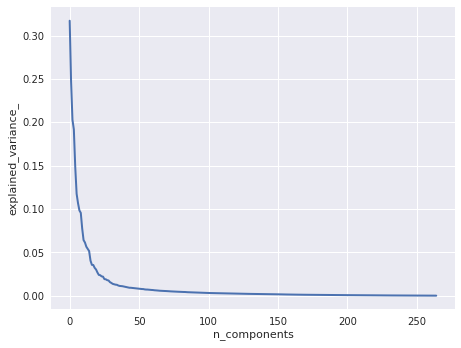

In [11]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

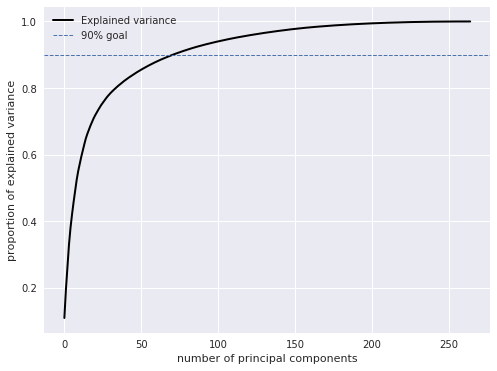

In [12]:
total_variance = np.sum(pca.explained_variance_)
cum_variance = np.cumsum(pca.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color = 'black', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend();

In [13]:
len(prop_var_expl[prop_var_expl <= 0.9])

71

In [14]:
df_rank_pca = pd.DataFrame(X_pca, index=df_w_rank.index)
df_rank_pca

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,264
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735503,0.421122,0.017534,0.030490,0.243384,0.231923,-0.359571,0.040509,...,-0.002120,0.000602,-0.010317,0.001093,-0.000096,0.000748,0.000421,0.000703,-0.000600,-0.000262
99726,-0.553772,0.919423,-0.563405,0.693138,0.492470,0.506488,0.254710,-0.667565,0.478517,0.084262,...,0.009360,0.000160,0.001203,-0.000147,-0.000960,0.000248,0.000067,0.000446,-0.000009,0.001680
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349306,0.202698,0.012140,-0.634208,-0.074446,...,0.000259,0.000007,-0.001400,0.000135,-0.002031,0.001249,0.000173,-0.000885,-0.000042,0.000494
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067705,0.449668,-0.391173,0.295403,-0.160394,...,-0.001041,-0.001971,0.000039,0.000592,0.000103,0.000003,-0.000538,-0.000701,0.000221,-0.000599
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872544,0.062129,-0.331749,-0.450992,0.038072,...,-0.001440,-0.000439,-0.003752,0.000145,0.000479,0.001264,-0.000703,-0.000054,-0.000106,0.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,-0.492690,-0.461529,0.077596,0.035290,-0.218350,0.116027,0.676679,-0.626119,0.378083,-0.271106,...,-0.001545,0.000331,0.001330,0.000739,-0.004231,0.000167,0.000411,0.000206,0.000138,-0.000998
99916,-0.610720,-0.477351,0.175739,0.605864,-0.083200,0.536619,0.216233,-1.029686,0.625074,-0.133925,...,-0.003522,0.000135,-0.001321,0.000334,-0.000161,-0.002245,0.000456,-0.000029,0.000046,-0.000667
101283,0.072873,-0.510824,-0.055954,0.054418,-0.351963,-0.368537,-0.174322,0.523298,0.773766,0.113511,...,-0.002044,0.001325,-0.003932,-0.000675,0.000201,-0.001402,-0.000088,0.000206,-0.000030,0.000939


In [16]:
sim_mat = cosine_similarity(df_rank_pca.values)

In [17]:
X = df_w_rank.to_numpy()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=71)
X_pca_71pc = pca.fit_transform(X_scaled)

### Exploring p

In [24]:
pca.components_

array([[ 5.51023519e-01,  2.95329172e-01, -5.17595572e-01, ...,
        -2.35255493e-03, -7.17522811e-03,  7.31207867e-04],
       [ 3.06862756e-01,  3.88867539e-01,  7.16760199e-01, ...,
         3.68687183e-03,  1.92881455e-03,  3.09870708e-03],
       [ 2.51196407e-01, -3.34803183e-01,  2.60711903e-01, ...,
        -5.51936131e-03,  1.00081594e-02,  1.13070331e-03],
       ...,
       [-2.57569413e-03, -1.40423767e-03,  1.10722445e-03, ...,
         4.28300280e-02,  3.37774384e-02, -8.17667199e-03],
       [-1.42341033e-03,  8.47841694e-04,  4.11619929e-06, ...,
        -2.82441222e-02,  4.71707775e-03,  1.65180740e-03],
       [ 2.43862216e-03,  4.74447203e-03,  2.76099805e-03, ...,
         3.39763801e-02,  1.45018843e-01,  6.89594907e-03]])

In [ ]:
df_rank_pca_71pc = pd.DataFrame(X_pca_71pc, 
                                index=df_w_rank.index)
df_rank_pca_71pc

In [ ]:
sim_mat_71pc = cosine_similarity(df_rank_pca_71pc.values)

In [ ]:
# PCA with 71 components
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, 
                                     df_rank_pca_71pc, 
                                     sim_mat_71pc, 
                                     n=10)
rec_list

In [ ]:
df_rank_pca_71pc.head()

In [ ]:
def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)



In [ ]:
def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [ ]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 5
top_n_comps = 10
print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_rank_pca_71pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('Common features: ', get_common_tags(top_n_ids))
    print('-----')